<a href="https://colab.research.google.com/github/JimKing100/DS-Unit-2-Applied-Modeling/blob/master/DS_Unit_2_Study_Guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module4')

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (77/77), done.
From https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
Checking out files: 100% (26/26), done.
     |████████████████████████████████| 92kB 5.8MB/s 
     |████████████████████████████████| 112kB 15.1MB/s 
     |████████████████████████████████| 133kB 54.7MB/s 
     |████████████████████████████████| 57.7MB 1.3MB/s 
     |████████████████████████████████| 245kB 45.3MB/s 
     |████████████████████████████████| 614kB 46.2MB/s 
     |████████████████████████████████| 235kB 47.0MB/s 
     |████████████████████████████████| 307kB 54.4MB/s 
     |████████████████████████████████| 215kB 52.9MB/s 
     |████████████████████████████████| 51kB 24.7MB/s 
     |████████████████████████████████| 737kB 37.9MB

In [0]:
import pandas as pd

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv('../data/lending-club/lending-club-subset.csv')
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv('../data/lending-club/primaryMarketNotes_browseNotes_1-RETAIL.csv')

In [0]:
# Transform earliest_cr_line to an integer:
# How many days the earliest credit line was open, before the loan was issued.
# For current loans available for manual investing, assume the loan will be issued today.
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

# Transform earliest_cr_line for the secondary applicant
history['sec_app_earliest_cr_line'] = pd.to_datetime(history['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
history['sec_app_earliest_cr_line'] = history['issue_d'] - history['sec_app_earliest_cr_line']
history['sec_app_earliest_cr_line'] = history['sec_app_earliest_cr_line'].dt.days

current['sec_app_earliest_cr_line'] = pd.to_datetime(current['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
current['sec_app_earliest_cr_line'] = pd.Timestamp.today() - current['sec_app_earliest_cr_line']
current['sec_app_earliest_cr_line'] = current['sec_app_earliest_cr_line'].dt.days

# Engineer features for issue date year & month
history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month

In [0]:
# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

In [0]:
# Train on the historical data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')
target = 'loan_status'
X = history.drop(columns=target)
y = history[target]

In [7]:
# Do train/validate/test 3-way split
from sklearn.model_selection import train_test_split

# Split into training/validation and test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

# Split training/validation into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 152)
y_train shape (88334,)
X_val shape (20000, 152)
y_val shape (20000,)
X_test shape (20000, 152)
y_test shape (20000,)


In [0]:
# Save the ids for later, so we can look up actual results,
# to compare with predicted results
train_id = X_train['id']
val_id = X_val['id']
test_id = X_test['id']

In [0]:
# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

In [0]:
# For features, use only the common columns shared by the historical & current data.
features = list(common_columns)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [11]:
def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    
    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # Convert sub_grade from string "A1"-"D5" to numbers
    sub_grade_ranks = {'A1': 1.1, 'A2': 1.2, 'A3': 1.3, 'A4': 1.4, 'A5': 1.5, 
                       'B1': 2.1, 'B2': 2.2, 'B3': 2.3, 'B4': 2.4, 'B5': 2.5, 
                       'C1': 3.1, 'C2': 3.2, 'C3': 3.3, 'C4': 3.4, 'C5': 3.5, 
                       'D1': 4.1, 'D2': 4.2, 'D3': 4.3, 'D4': 4.4, 'D5': 4.5}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Reset index
    X = X.reset_index(drop=True)
    
    # Return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (88334, 66)
X_val shape (20000, 66)
X_test shape (20000, 66)


In [12]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.669638	validation_1-auc:0.672822
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.670802	validation_1-auc:0.674118
[2]	validation_0-auc:0.676142	validation_1-auc:0.680087
[3]	validation_0-auc:0.679771	validation_1-auc:0.683186
[4]	validation_0-auc:0.682482	validation_1-auc:0.684256
[5]	validation_0-auc:0.683905	validation_1-auc:0.685868
[6]	validation_0-auc:0.685104	validation_1-auc:0.687372
[7]	validation_0-auc:0.685857	validation_1-auc:0.687737
[8]	validation_0-auc:0.685805	validation_1-auc:0.687888
[9]	validation_0-auc:0.686504	validation_1-auc:0.689168
[10]	validation_0-auc:0.686866	validation_1-auc:0.689461
[11]	validation_0-auc:0.686938	validation_1-auc:0.689288
[12]	validation_0-auc:0.687537	validation_1-auc:0.69022
[13]	validation_0-auc:0.688371	validation_1-auc:0.690954
[14]	validation_0-auc:0.688811	validation_1-auc:0.691599

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [19]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.709825059932263


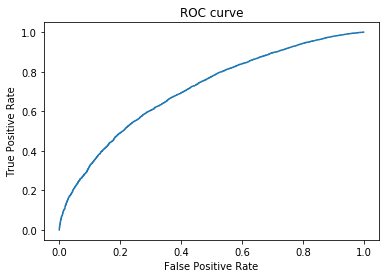

In [22]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test=='Charged Off', y_pred_proba)
plt.plot(tpr, fpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');